In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
labels = ['Fresh apple', 'Fresh banana', 'Fresh orange', 'Rotten apple', 'Rotten banana', 'Rotten orange']

# Load base model

In [4]:
base_model = keras.applications.VGG16(include_top=False, # to be able to add layers
                                      weights='imagenet', input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


# Freeze model

In [5]:
base_model.trainable = False

# Add layers to model

In [6]:
inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(6,activation='softmax')(x)
model = keras.Model(inputs,outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


# Augment the data

In [8]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    samplewise_center = True,
    horizontal_flip = True,
    zoom_range = 0.1
)

# Load data

In [9]:
train = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/assessment/data/fruits/train',
    target_size=(224,224),
    color_mode = 'rgb',
    class_mode = 'categorical'
)

valid = datagen.flow_from_directory(
    directory = '/content/drive/MyDrive/assessment/data/fruits/valid',
    target_size=(224,224),
    color_mode = 'rgb',
    class_mode = 'categorical'
)

Found 1170 images belonging to 6 classes.
Found 329 images belonging to 6 classes.


# Train the model

Plot the model accuracy

In [10]:
def plot_model_accuracy(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = np.array(history.epoch) + 1
    plt.plot(epochs, train_acc, label='training accuracy')
    plt.plot(epochs,val_acc, label ='validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

Compile the model

In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])


Train the model

In [13]:
history = model.fit(train, 
        validation_data=valid, 
        steps_per_epoch=train.samples/train.batch_size,
        validation_steps=valid.samples/valid.batch_size,
        epochs=15)
model.evaluate(valid,steps=valid.samples/valid.batch_size)[1]

Epoch 1/15
36/36 [==============================] - 694s 19s/step - loss: 0.1685 - accuracy: 0.9427 - val_loss: 0.2577 - val_accuracy: 0.9271
Epoch 2/15
36/36 [==============================] - 691s 19s/step - loss: 0.1200 - accuracy: 0.9564 - val_loss: 0.2052 - val_accuracy: 0.9422
Epoch 3/15
36/36 [==============================] - 744s 20s/step - loss: 0.0907 - accuracy: 0.9667 - val_loss: 0.2137 - val_accuracy: 0.9392
Epoch 4/15
36/36 [==============================] - 689s 19s/step - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.1848 - val_accuracy: 0.9514
Epoch 5/15
36/36 [==============================] - 690s 19s/step - loss: 0.0731 - accuracy: 0.9769 - val_loss: 0.1404 - val_accuracy: 0.9544
Epoch 6/15
36/36 [==============================] - 691s 19s/step - loss: 0.0521 - accuracy: 0.9821 - val_loss: 0.1678 - val_accuracy: 0.9514
Epoch 7/15
36/36 [==============================] - 688s 19s/step - loss: 0.0664 - accuracy: 0.9735 - val_loss: 0.1760 - val_accuracy: 0.9635
Epoch 

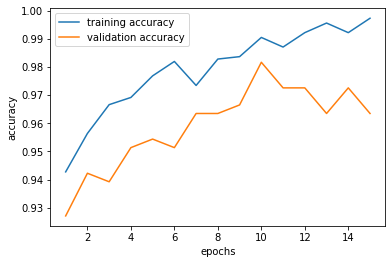

In [15]:
plot_model_accuracy(history)

In [16]:
folder = '/content/drive/MyDrive/assessment/data/fruits/test'

images = []
for filename in os.listdir(folder):
    img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(224,224))
    if img is not None:
        images.append(img)
image_pred = images.copy()

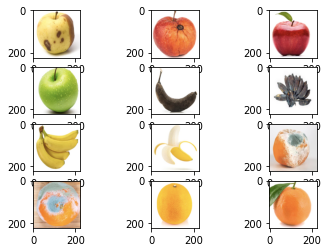

In [17]:
_, ax = plt.subplots(4,3)
for i in range(0,12):
    image = images[i]
    ax.flatten()[i].imshow(image,cmap='gray')
plt.show()

In [18]:
for i in range(len(images)):
    images[i] = img_to_array(images[i])
    # images[i] /= 255
    images[i] = images[i].reshape(1,224,224,3)

In [19]:
prediction = model.predict(images[0])
print(np.argmax(prediction))
print(labels[np.argmax(prediction)])

3
Rotten apple


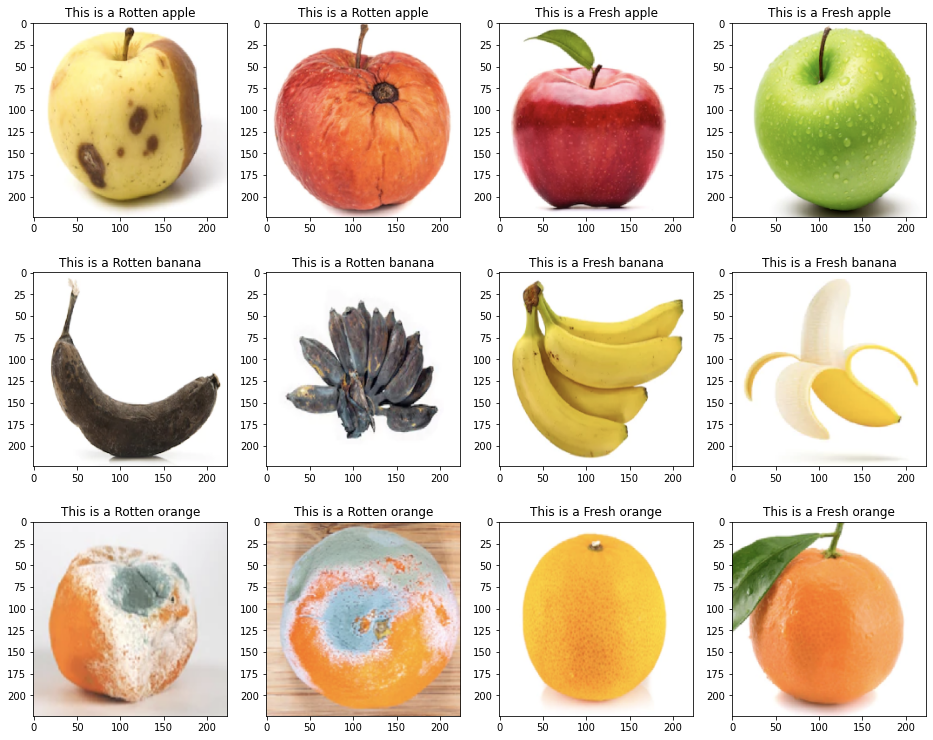

In [22]:
fig = plt.figure(figsize=(16,13))
ax = fig.subplots(3,4)
for i in range(12):
    img = image_pred[i]
    pred = labels[np.argmax(model.predict(images[i]))]
    ax.flatten()[i].imshow(img,cmap='gray')
    ax.flatten()[i].title.set_text("This is a " + pred)
plt.show()